#### 1. 使用豆瓣电影评论数据完成文本分类处理：文本预处理，加载、构建词典。（评论得分1～2 表示positive取值：1，评论得分4～5代表negative取值：0）
#### 2. 加载处理后文本构建词典、定义模型、训练、评估、测试。
#### 3. 尝试不同分词工具进行文本分词，观察模型训练结果。



In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("utmhikari/doubanmovieshortcomments")

print("Path to dataset files:", path)

/opt/miniconda3/envs/py312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/peiqi/.cache/kagglehub/datasets/utmhikari/doubanmovieshortcomments/versions/7


In [4]:
#文本预处理
import csv
import jieba

ds_comments = []

with open('/Users/peiqi/code/AiPremiumClass/李思佳/week07/DMSC.csv', 'r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        vote = int(row['Star'])
        if vote in [1,2,4,5]:
            words = jieba.lcut(row['Comment'])
            if vote in [1, 2]:
                ds_comments.append((words, 0))
            elif vote in [4, 5]:
                ds_comments.append((words, 1)) #1好评 0差评

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/tl/s657k2kn70zdpt9vn9hq4cpm0000gq/T/jieba.cache
Loading model cost 0.412 seconds.
Prefix dict has been built successfully.


In [ ]:
#尝试不同分词工具进行文本分词，观察模型训练结果。
#实验发现thulac分词的模型训练损失率下降比jieba分词损失率下降慢

import csv
import thulac

# Initialize THULAC
thu1 = thulac.thulac(seg_only=True)  # 只进行分词，不进行词性标注

ds_comments = []

with open('/Users/peiqi/code/AiPremiumClass/李思佳/week07/DMSC.csv', 'r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        vote = int(row['Star'])
        if vote in [1, 2, 4, 5]:
            # Use THULAC for word segmentation
            words = thu1.cut(row['Comment'], text=True).split()
            if vote in [1, 2]:
                ds_comments.append((words, 0))
            elif vote in [4, 5]:
                ds_comments.append((words, 1))  # 1好评 0差评


Model loaded succeed


<function matplotlib.pyplot.show(close=None, block=None)>

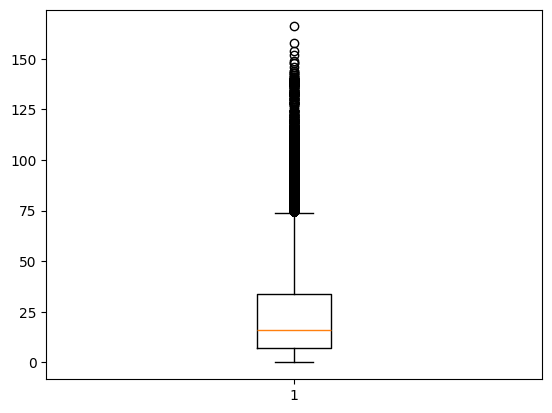

In [4]:
#### 分析评论长度，考虑截取过长、过短评论
import matplotlib.pyplot as plt

comments_len = [len(c) for c, v in ds_comments]
# plt.hist(comments_len, bins=100)
# plt.show
plt.boxplot(comments_len)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

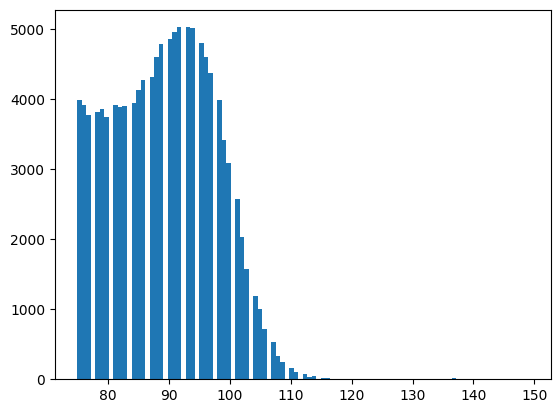

In [6]:
#评论词汇长度在10-150之前

ds_comments = [c for c in ds_comments if len(c[0]) in range(75, 150)]

comments_len = [len(c) for c, v in ds_comments]
plt.hist(comments_len, bins=100)
plt.show

In [7]:
import pickle

with open('/Users/peiqi/code/AiPremiumClass/李思佳/week07/dbpl.pkl','wb') as f:
    pickle.dump(ds_comments, f)

In [8]:
#加载训练语料
with open('/Users/peiqi/code/AiPremiumClass/李思佳/week07/dbpl.pkl', 'rb') as f:
    comments_data = pickle.load(f)

#构建词典
def build_from_doc(doc):
    vocab = set()
    for line in doc:
        if line[0] is not None:
            vocab.update(line[0])
    # 移除可能存在的 None
    vocab.discard(None)
    vocab = ['PAD','UNK'] + list(vocab) #pad :padding, unk: unknown
    w2idx = {word:idx for idx, word in enumerate(vocab)}
    print(w2idx)
    return w2idx

vocab = build_from_doc(comments_data)

{'PAD': 0, 'UNK': 1, '半疼': 2, '全身为': 3, '天作': 4, '潮退': 5, '通笑': 6, '重标': 7, 'IMAX杜比': 8, '饰演者': 9, 'range': 10, '凋零': 11, '雷用': 12, '于脑': 13, '参上': 14, '突如其': 15, '酱弥': 16, '嫌慢': 17, '工具男': 18, '陪泷': 19, '布景什': 20, '强撕': 21, '度怎': 22, '贼心不死': 23, '我09年': 24, '女训': 25, '习作': 26, '相权': 27, '搜索death': 28, '锤打': 29, '某圈': 30, '需': 31, 'all句号': 32, '扔沟': 33, 'Ford镜头': 34, '刘大哥': 35, '哈哈声': 36, '悲叹': 37, '场哦': 38, '终害': 39, '破十亿': 40, '山腰': 41, '诺言': 42, '纪实度': 43, '外为': 44, '萌动': 45, '海棠者': 46, '「催': 47, '國產片': 48, '整喜': 49, '买椟还珠': 50, '乱伦戏': 51, '大雨磅礴': 52, '黏黏': 53, '断气': 54, '海雅缤纷城': 55, '精英主义者': 56, '研究者': 57, '以小人之心度君子之腹': 58, '搭帅哥': 59, '垢': 60, '菜系': 61, '北非': 62, '救赎者': 63, '树影': 64, 'Don': 65, '山洞': 66, '囊括': 67, '征战': 68, '说话娘': 69, '歌特': 70, '磨皮擦痒': 71, '民夫': 72, '僵局': 73, '鐘愛': 74, '书法': 75, '起见': 76, '黑到尾': 77, '高铁远': 78, '张嘴然': 79, 'superhero大杂烩': 80, 'malade': 81, '椿赎罪': 82, '烦金': 83, '超出': 84, '必诛': 85, '披散': 86, '椿更': 87, '投注': 88, '情什': 89, '帅气嘴': 90, '批斗': 91, '的给不了': 92

In [10]:
len(vocab)

181329

In [11]:
# 通过dataset构建DataLoader
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence #长度不同的张量填充为相同长度
import torch

#自定义回调函数
#自定义数据转换方法（callback function 回调函数）
def convert_data(batch_data):
    comments, votes = [], []
    # 分别提取评论和标签
    for comment, vote in batch_data:
        comments.append(torch.tensor([vocab.get(word, vocab['UNK']) for word in comment]))
        votes.append(vote)
    # 将评论和标签统一转换为张量
    commt =  pad_sequence(comments, batch_first=True, padding_value=vocab['PAD']) #填充为相同长度，batch_first批次在第0个位置，
    labels = torch.tensor(votes)
    return commt, labels

dataloader = DataLoader(comments_data, batch_size=128, shuffle=True,collate_fn=convert_data)  #collate_fn：回调,惰性方法



In [12]:
#构建模型
import torch.nn as nn
class Comments_Classifier(nn.Module):
    def __init__(self, vocal_size, embedding_dim, hidden_size, num_classes):
        super().__init__()
        self.embedding =nn.Embedding(vocal_size, embedding_dim, padding_idx=0)
        self.rnn = nn.LSTM(embedding_dim, hidden_size,batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, input_ids):
        #input_ids:{batch_size, seq_len}
        #embedded:{batch_size, seq_len, embeding_dim} seq_len:训练长度
        embedded = self.embedding(input_ids)    
        # output:(batch_size, seq_len, hidden_size)
        output, (hidden, _) = self.rnn(embedded)
        output = self.fc(output[:,-1,:]) #取最后一个时间步的输出
        return output
    
    
embedding_dim = 200
hidden_size = 10
num_classes = 2
vocab_size = len(vocab)

emb = nn.Embedding(len(vocab), embedding_dim) #词汇表大小len(vocab)，向量维度100

model = Comments_Classifier(len(vocab),embedding_dim,hidden_size, num_classes )
print(model)

#定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#训练模型
num_epoch = 3
for epochs in range(num_epoch):
    for i, (cmt, lbl) in enumerate(dataloader):
        #前向传播
        outputs = model(cmt)
        loss = criterion(outputs, lbl)
        #反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 10 == 0:
            print(f'Epoch [{epochs+1}/{num_epoch}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}')


Comments_Classifier(
  (embedding): Embedding(181329, 200, padding_idx=0)
  (rnn): LSTM(200, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=2, bias=True)
)
Epoch [1/3], Step [10/946], Loss: 0.5747
Epoch [1/3], Step [20/946], Loss: 0.6018
Epoch [1/3], Step [30/946], Loss: 0.5696
Epoch [1/3], Step [40/946], Loss: 0.5312
Epoch [1/3], Step [50/946], Loss: 0.4929
Epoch [1/3], Step [60/946], Loss: 0.5224
Epoch [1/3], Step [70/946], Loss: 0.5139
Epoch [1/3], Step [80/946], Loss: 0.4983
Epoch [1/3], Step [90/946], Loss: 0.5533
Epoch [1/3], Step [100/946], Loss: 0.4089
Epoch [1/3], Step [110/946], Loss: 0.5082
Epoch [1/3], Step [120/946], Loss: 0.4642
Epoch [1/3], Step [130/946], Loss: 0.4490
Epoch [1/3], Step [140/946], Loss: 0.4838
Epoch [1/3], Step [150/946], Loss: 0.5179
Epoch [1/3], Step [160/946], Loss: 0.5062
Epoch [1/3], Step [170/946], Loss: 0.5230
Epoch [1/3], Step [180/946], Loss: 0.4260
Epoch [1/3], Step [190/946], Loss: 0.4861
Epoch [1/3], Step [200/946], Loss: 0

In [17]:
#构建模型
import torch.nn as nn
class Comments_Classifier(nn.Module):
    def __init__(self, vocal_size, embedding_dim, hidden_size, num_classes):
        super().__init__()
        self.embedding =nn.Embedding(vocal_size, embedding_dim, padding_idx=0)
        self.rnn = nn.LSTM(embedding_dim, hidden_size,batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, input_ids):
        #input_ids:{batch_size, seq_len}
        #embedded:{batch_size, seq_len, embeding_dim} seq_len:训练长度
        embedded = self.embedding(input_ids)    
        # output:(batch_size, seq_len, hidden_size)
        output, (hidden, _) = self.rnn(embedded)
        output = self.fc(output[:,-1,:]) #取最后一个时间步的输出
        return output
    
    
embedding_dim = 200
hidden_size = 10
num_classes = 2
vocab_size = len(vocab)

emb = nn.Embedding(len(vocab), embedding_dim) #词汇表大小len(vocab)，向量维度100

model = Comments_Classifier(len(vocab),embedding_dim,hidden_size, num_classes )
print(model)

#定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#训练模型
num_epoch = 3
for epochs in range(num_epoch):
    for i, (cmt, lbl) in enumerate(dataloader):
        #前向传播
        outputs = model(cmt)
        loss = criterion(outputs, lbl)
        #反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 10 == 0:
            print(f'Epoch [{epochs+1}/{num_epoch}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item():.4f}')


Comments_Classifier(
  (embedding): Embedding(181329, 200, padding_idx=0)
  (rnn): LSTM(200, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=2, bias=True)
)
Epoch [1/3], Step [10/946], Loss: 0.7255
Epoch [1/3], Step [20/946], Loss: 0.6966
Epoch [1/3], Step [30/946], Loss: 0.6616
Epoch [1/3], Step [40/946], Loss: 0.6246
Epoch [1/3], Step [50/946], Loss: 0.6062
Epoch [1/3], Step [60/946], Loss: 0.5723
Epoch [1/3], Step [70/946], Loss: 0.5583
Epoch [1/3], Step [80/946], Loss: 0.4838
Epoch [1/3], Step [90/946], Loss: 0.4485
Epoch [1/3], Step [100/946], Loss: 0.4742
Epoch [1/3], Step [110/946], Loss: 0.5085
Epoch [1/3], Step [120/946], Loss: 0.4488
Epoch [1/3], Step [130/946], Loss: 0.5113
Epoch [1/3], Step [140/946], Loss: 0.5068
Epoch [1/3], Step [150/946], Loss: 0.3918
Epoch [1/3], Step [160/946], Loss: 0.5860
Epoch [1/3], Step [170/946], Loss: 0.4931
Epoch [1/3], Step [180/946], Loss: 0.5592
Epoch [1/3], Step [190/946], Loss: 0.5568
Epoch [1/3], Step [200/946], Loss: 0

In [18]:
# 保存模型
torch.save(model.state_dict(), '/Users/peiqi/code/AiPremiumClass/李思佳/week07/comments_classifier.pth')
#保存词典
torch.save(vocab, '/Users/peiqi/code/AiPremiumClass/李思佳/week07/comments_vocab.path')

In [22]:
import jieba
# 测试模型
commet1 = "这电影真好看，全程无尿点"
commet2 = "看一半就不想看了，真无聊"

vocab = torch.load('/Users/peiqi/code/AiPremiumClass/李思佳/week07/comments_vocab.path', weights_only=False)
# vocab = list(vocab)
# 将评论转化为索引

commet1_idx = torch.tensor([vocab.get(word, vocab['UNK']) for word in jieba.lcut(commet1)])
commet2_idx = torch.tensor([vocab.get(word, vocab['UNK']) for word in jieba.lcut(commet2)])
# #将评论转化为tensor
commet1_idx = commet1_idx.unsqueeze(0) #添加batch维度
commet2_idx = commet2_idx.unsqueeze(0) #添加batch维度

# 加载模型
model = Comments_Classifier(len(vocab),embedding_dim,hidden_size, num_classes )
model.load_state_dict(torch.load('/Users/peiqi/code/AiPremiumClass/李思佳/week07/comments_classifier.pth', weights_only=False))

#模型推理
pred1 = model(commet1_idx)
pred2= model(commet2_idx)

#取最大值的索引作为预测结果
pred1 = torch.argmax(pred1, dim=1).item()
pred2 = torch.argmax(pred2, dim=1).item()

print(pred1)
print(pred2)

1
0
